# **Dataset Cleaning**

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
import math

In [69]:
df = pd.read_csv("../input/diamonds_train.csv")
df.drop(columns="Unnamed: 0",inplace=True)

## **1. Know the characteristics affecting the quality and price of a diamond**

### **Take a first look at the dataset** 

- Get an idea about the number of columns and rows and data in them
- Know the meaning of each column

In [70]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


In [71]:
df.shape

(40345, 10)

**At first glance, dataset contains 40345 records and 9 features (predictive values) and a column with the feature to predict, the price of diamonds**

##### Meaning of the features (or columns):
- price: price in USD
- carat: weight of the diamond
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour, from J (worst) to D (best)
- clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x: length in mm
- y: width in mm
- z: depth in mm
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: width of top of diamond relative to widest point (43--95)

### **Rename some columns to make them easier to read**

In [72]:
df = df.rename(columns={"depth":"depth(%)","table":"table(%)", "x":"length","y":"width","z":"depth"})
df.head()

,carat,cut,color,clarity,depth(%),table(%),length,width,depth,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


### **Important info to keep in mind about the characteristics of diamonds affecting their value**


- The 4 main characteristics for their value are `carat`, `clarity`, `cut` and `color`. 
- From these 4 characteristics, carat is the only numerical characteristic.
- But `size` matters too. Carat and size are not the same: Carat is the weight of diamond. The higher value of carat the more expensive the diamond will be. However, if two diamonds have the same carat value but different size measures, the largest one will have a high price.

## **2. Analyze and transform the features of the dataset**

### **Get info about number of null values and type of values by columns**

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40345 entries, 0 to 40344
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   carat     40345 non-null  float64
 1   cut       40345 non-null  object 
 2   color     40345 non-null  object 
 3   clarity   40345 non-null  object 
 4   depth(%)  40345 non-null  float64
 5   table(%)  40345 non-null  float64
 6   length    40345 non-null  float64
 7   width     40345 non-null  float64
 8   depth     40345 non-null  float64
 9   price     40345 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


- No null values in columns
- Columns "cut", "color" and "clarity" are categorical. Before converting their values to ordinal, analyze statistical data of numeric columns

In [74]:
df.describe()

,carat,depth(%),table(%),length,width,depth,price
count,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000
mean,0.795652,61.750413,57.460302,5.726106,5.730217,3.535136,3924.089924
std,0.470806,1.424219,2.235333,1.118690,1.148584,0.693662,3982.000515
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,948.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2395.000000
75%,1.040000,62.500000,59.000000,6.540000,6.530000,4.030000,5313.000000
max,4.010000,79.000000,95.000000,10.020000,58.900000,8.060000,18818.000000


Relevant info from summary of statistical data:

- Some values in features "width", "length" and "depth" are equal to zero --> Remove these rows
- Some values in feature "width" are greater than an expected value for diamond size --> check and remove if necessary

### **Remove rows with wrong data**

- **Remove values from columns related to size of diamonds ("width", "lenght", "depth") that are equal to 0 mm**

In [75]:
# Remove values == 0 from columns about diamond size
sizes_cero = df[(df["width"]==0.0)|(df["depth"]==0.0)|(df["length"]==0.0)].index
sizes_cero

Int64Index([ 4960,  5127,  6571, 10971, 12572, 15252, 15518, 18027, 18658,
            20916, 23417, 24641, 24846, 25671, 28570, 36145, 40203],
           dtype='int64')

In [76]:
df.drop(index=sizes_cero, inplace=True)

- **Check and remove (if necessary) odd values from column "width" --> diamond with a width greater than 11 mm could be odd**

In [77]:
# Find values of width greater than 11 mm
df["width"].unique()[df["width"].unique()>11]

array([31.8, 58.9])

In [78]:
# Just two values greater than 11mm in width column. Take a look in the rows of those values
df[df["width"]>11]

,carat,cut,color,clarity,depth(%),table(%),length,width,depth,price
33575,0.51,Ideal,E,VS1,61.8,55.0,5.15,31.8,5.12,2075
34424,2.00,Premium,H,SI2,58.9,57.0,8.09,58.9,8.06,12210


Since these two high values of width are not in parallel with the other measurements of sizes and "carat", these two rows are removed.

In [79]:
# Select rows of dataset whose width value is less than or equal to 11mm
df = df[df["width"]<=11]
display(df.shape)
df.head()

(40326, 10)

,carat,cut,color,clarity,depth(%),table(%),length,width,depth,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


### **Correlation between features**

In [80]:
corr_ma = df.corr()
corr_ma[corr_ma>0.8]

,carat,depth(%),table(%),length,width,depth,price
carat,1.000000,NaN,NaN,0.978397,0.977548,0.976846,0.921881
depth(%),NaN,1.0,NaN,NaN,NaN,NaN,NaN
table(%),NaN,NaN,1.0,NaN,NaN,NaN,NaN
length,0.978397,NaN,NaN,1.000000,0.998622,0.990925,0.886655
width,0.977548,NaN,NaN,0.998622,1.000000,0.990627,0.888368
depth,0.976846,NaN,NaN,0.990925,0.990627,1.000000,0.881395
price,0.921881,NaN,NaN,0.886655,0.888368,0.881395,1.000000


**Except "table(%)" and "depth(%)" features, all features are highly correlated between them and with price data.**

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

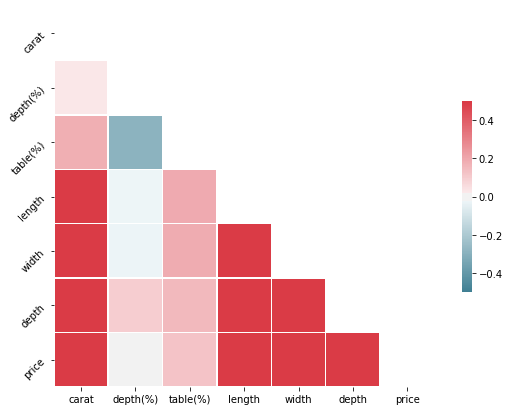

In [81]:
mask = np.zeros_like(corr_ma, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_ma, mask=mask, cmap=cmap, vmin=-0.5,vmax=0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=45)

**Conclusions from correlation matrix and heatmap plot:**

1) Feature `carat` has a high correlation with features about diamond size (`width`,`length` and `depth`). This makes sense, since carat feature is the diamond weight. However, as discussed above, diamonds with same carats but different sizes may have different prices. So, because **these 4 features provide different info** about diamond, I am not going to remove none of them.

2) Morever, these 4 features have a high correlation with price. Therefore, they are important to know the price of a diamond.

3) `Table(%)` (ratio between `table width` and `total width`) seems to not provide relevant info about price.

4) As table(%), `depth(%)` seems to contain not significant information

### **Tranform the feature `table(%)`**

Table(%) is an important data because is related to the light reflection capabilities of the diamond. Despite this,  if we observe the correlation between table(%) and price, table(%) seems not to provide much info about the price. 

An optimal table(%) is in a range of 53 to 58%. Since table(%) is a "table width" to "total width" ratio, table(%) can takes these values (53-58%) as long as "table width" value is half the "total width" value.

However, diamonds with larger sizes are more expensive than those with smaller sizes. Therefore, instead of table(%), "table width" may be a more interesting feature, because it can provide more relevant information during the model training in combination with "total width". 

Only diamonds with an appropriate "table width" and "total width" will have a high price due to their size and their ability to reflect light.

In [82]:
df["table"] = (df["table(%)"]/100)*df["width"]

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

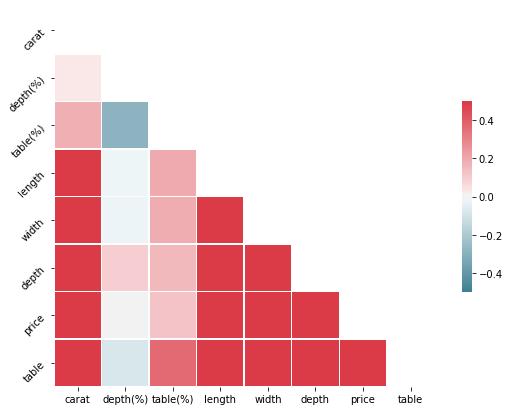

In [83]:
corr_ma = df.corr()
#corr_ma[corr_ma>0.8]
mask = np.zeros_like(corr_ma, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_ma, mask=mask, cmap=cmap, vmin=-0.5,vmax=0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=45)

Analyzing "table" and "table(%)", it can be observed how "table" correlates better with the other features and also with price. Therefore, keep "table" feature and remove "table(%)"

In [84]:
df.drop(columns="table(%)",inplace=True)

### **Remove `depth(%)` feature**

Depth(%) feature is also related to the diamond capability of reflecting light. The optimal depth(%) is in a range from 59 to 63%.

`Depth(%)` is calculated as a combination of the values `width`, `length` and `depth`. Since an optimal depth(%) can be achieve by a larger diamond as well as a smaller one, features width, length and depth are more important to calculate price of a diamond and, therefore, depth(%) may provide redundant information.

In [85]:
df.drop(columns="depth(%)",inplace=True)

### **Distribution of numeric features**

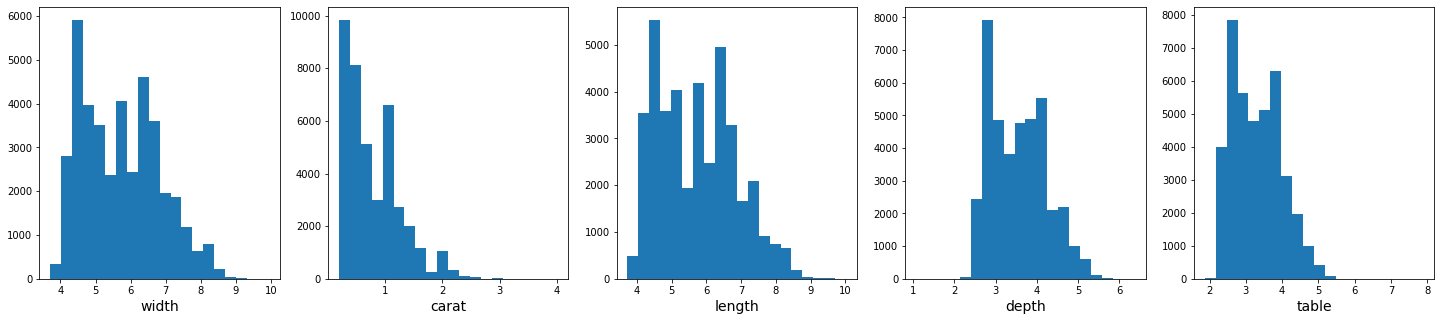

In [86]:
numeric_columns = ["width","carat","length","depth","table"]
X = df[numeric_columns]

plt.figure(figsize=(25,5))
for i in range(X.shape[1]):
    plt.subplot(1,X.shape[1],i+1)
    plt.hist(X.iloc[:,i],bins=20)
    plt.xlabel(X.iloc[:,i].name, fontsize=14)

The distributions of most of the features look like a normal distribution, except in the feature "carat". Therefore, values form this feature will be transform so that its distribution is a normal distribution.

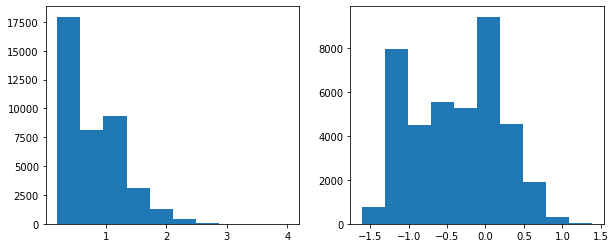

In [87]:
# Since "carat" feature has an exponential distribution, apply log to values. 
df["carat_log"] = df["carat"].apply(math.log)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["carat"],bins=10)
plt.subplot(1,2,2)
plt.hist(df["carat_log"],bins=10)
plt.show()

In [88]:
df.drop(columns="carat",inplace=True)
df.head()

,cut,color,clarity,length,width,depth,price,table,carat_log
0,Ideal,H,VS2,6.73,6.70,4.23,6134,3.8190,0.190620
1,Very Good,D,VVS2,4.14,4.17,2.66,532,2.3352,-1.272966
2,Premium,F,VS1,4.86,4.82,2.96,1103,2.7956,-0.867501
3,Ideal,H,IF,4.16,4.12,2.53,600,2.3484,-1.347074
4,Good,G,SI1,6.52,6.55,4.14,4997,3.7335,0.095310


### **Outliers in numeric features**

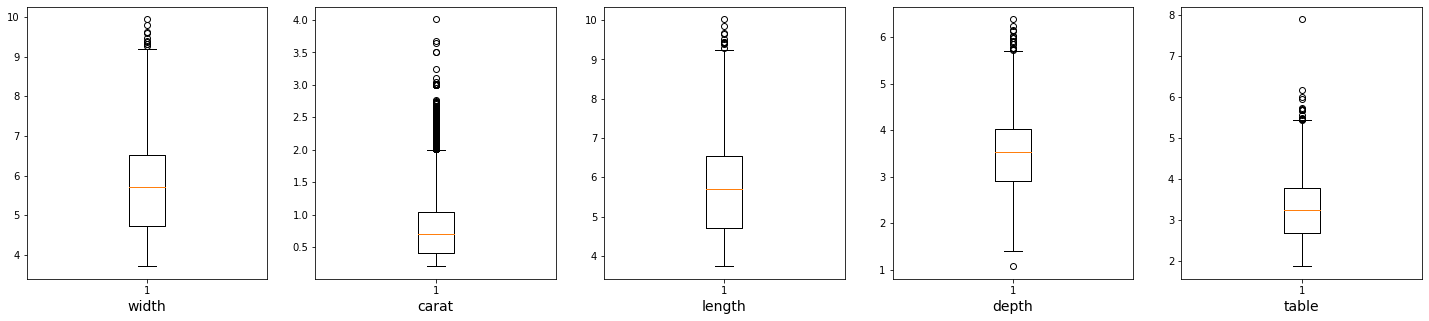

In [89]:
plt.figure(figsize=(25,5))
for i in range(X.shape[1]):
    plt.subplot(1,X.shape[1],i+1)
    plt.boxplot(X.iloc[:,i])
    plt.xlabel(X.iloc[:,i].name, fontsize=14)

At this moment, outliers are not going to be removed because these higher values could correspond with the most expensive diamonds.

### **Change categorical values in features `cut`, `color`, `clarity` to ordinal** 

First, have a look to different values in columns "cut", "color" and "clarity"

In [90]:
display(df.cut.value_counts(),df.color.value_counts(),df.clarity.value_counts())

Ideal        16086
Premium      10329
Very Good     9035
Good          3691
Fair          1185
Name: cut, dtype: int64

G    8492
E    7350
F    7127
H    6228
D    5073
I    4022
J    2034
Name: color, dtype: int64

SI1     9749
VS2     9175
SI2     6820
VS1     6099
VVS2    3858
VVS1    2713
IF      1362
I1       550
Name: clarity, dtype: int64

**To take into account:** These features are not balanced. There are in different proportions. 

Create lists of the categories to change ordered from worst to best to calculate diamond price

In [91]:
# Cuts are already ordered by value_counts from the worst (Fair: 0) to the best (Ideal: 4)
# Colors will be ordered by reversed alphabetical order from the worst (J:0) to the best (D:6)
# Clarities have to be ordered "by hand" from the worst (I1: 0) to the best (IF:7)
cuts = list(df.cut.value_counts().sort_values().index)
colors = list(df.color.value_counts().index.sort_values(ascending=False))
clarities = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]

Create new columns from the categorical ones, converting the attribute to a number

In [92]:
# Functions to convert features from categorical to numerical given a ordered categories
categorical_columns = {"cut":cuts,"color":colors,"clarity":clarities}
for key,value in categorical_columns.items():
    df[key] = pd.Categorical(df[key], categories = value, ordered = True)
    df[f"{key}_num"] = df[key].cat.codes

Finally, remove categorical columns

In [93]:
df.drop(columns=["cut","color","clarity"],inplace=True)
df.head()

,length,width,depth,price,table,carat_log,cut_num,color_num,clarity_num
0,6.73,6.70,4.23,6134,3.8190,0.190620,4,2,3
1,4.14,4.17,2.66,532,2.3352,-1.272966,2,6,5
2,4.86,4.82,2.96,1103,2.7956,-0.867501,3,4,4
3,4.16,4.12,2.53,600,2.3484,-1.347074,4,2,7
4,6.52,6.55,4.14,4997,3.7335,0.095310,1,3,2


### **Correlation between all features**

In [94]:
corr_ma = df.corr()
corr_ma[corr_ma>0.8]

,length,width,depth,price,table,carat_log,cut_num,color_num,clarity_num
length,1.000000,0.998622,0.990925,0.886655,0.981370,0.992971,NaN,NaN,NaN
width,0.998622,1.000000,0.990627,0.888368,0.981428,0.992600,NaN,NaN,NaN
depth,0.990925,0.990627,1.000000,0.881395,0.965830,0.991723,NaN,NaN,NaN
price,0.886655,0.888368,0.881395,1.000000,0.864877,0.855094,NaN,NaN,NaN
table,0.981370,0.981428,0.965830,0.864877,1.000000,0.974198,NaN,NaN,NaN
carat_log,0.992971,0.992600,0.991723,0.855094,0.974198,1.000000,NaN,NaN,NaN
cut_num,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
color_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
clarity_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text major ticklabel objects>)

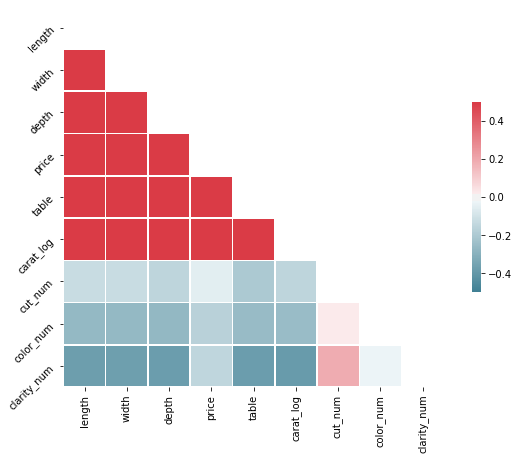

In [95]:
mask = np.zeros_like(corr_ma, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_ma, mask=mask, cmap=cmap, vmin=-0.5,vmax=0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=45)

There are a high correlation between features based on measures of diamond size and weight, but a small correlation o reversed correlation between with qualitative features. However these characteristics may be useful to value diamonds with similar characteristics of size.

## **3. Save the predictive features and the column to predict to train models**

In [96]:
X_analysis = df.drop(columns="price")

In [97]:
X_analysis.head()

,length,width,depth,table,carat_log,cut_num,color_num,clarity_num
0,6.73,6.70,4.23,3.8190,0.190620,4,2,3
1,4.14,4.17,2.66,2.3352,-1.272966,2,6,5
2,4.86,4.82,2.96,2.7956,-0.867501,3,4,4
3,4.16,4.12,2.53,2.3484,-1.347074,4,2,7
4,6.52,6.55,4.14,3.7335,0.095310,1,3,2


In [98]:
y_analysis = df["price"]

In [99]:
X_analysis.to_csv("../output/X.csv")
y_analysis.to_csv("../output/y.csv")